In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
import sys
sys.path.append('../../')

from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)


0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [ ]:
#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain'),
    #('policy','antibiotics'),
    #('self_empl','days_at_home')
])

def BN_model_train(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN

In [ ]:
def XGBoost_model_train(symt, df_train, df_test, emb='hist_emb'):
    """
    Huấn luyện mô hình XGBoost cho một triệu chứng cụ thể.

    Args:
        symt (str): Tên triệu chứng cần huấn luyện.
        df_train (DataFrame): Tập huấn luyện.
        df_test (DataFrame): Tập kiểm tra.

    Returns:
        Tuple: (precision, recall, f1, accuracy), model đã huấn luyện.
    """
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train[emb].tolist())
    X_test = np.array(df_test[emb].tolist())

    # Xử lý nhãn
    if symt == 'fever':  # Nếu là bài toán nhiều lớp
        y_train = df_train[symt].values
        y_test = df_test[symt].values
        num_classes = len(np.unique(y_train))
        objective = 'multi:softmax'
    else:  # Nếu là bài toán nhị phân
        y_train = df_train[symt].values
        y_test = df_test[symt].values
        num_classes = 2
        objective = 'binary:logistic'

    # Định nghĩa mô hình XGBoost
    model = xgb.XGBClassifier(
        objective=objective,
        num_class=num_classes if symt == 'fever' else None,
        eval_metric="mlogloss" if symt == 'fever' else "logloss",
        use_label_encoder=False,
        eta=0.1,  # Learning rate
        max_depth=6,
        n_estimators=100
    )

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Tính độ đo đánh giá
    precision = precision_score(y_test, y_pred, average='weighted' if symt == 'fever' else 'binary')
    recall = recall_score(y_test, y_pred, average='weighted' if symt == 'fever' else 'binary')
    f1 = f1_score(y_test, y_pred, average='weighted' if symt == 'fever' else 'binary')
    accuracy = accuracy_score(y_test, y_pred)

    scores = [precision, recall, f1, accuracy]
    return scores, model


In [8]:
def test_XGBoost(XG_models, test_df, emb='hist_emb'):
    """
    Kiểm tra mô hình bằng cách chạy tập test qua 5 mô hình XGBoost riêng biệt.

    Args:
        XG_models: Dictionary chứa 5 mô hình XGBoost cho từng triệu chứng.
        test_df: DataFrame chứa tập test, phải có cột 'emb'.
        emb: Tên cột chứa embedding.

    Returns:
        feature_df: DataFrame chứa đặc trưng từ mô hình.
    """

    # Bước 1: Kiểm tra embeddings
    if emb not in test_df:
        raise ValueError(f"Lỗi: Không tìm thấy cột '{emb}' trong test_df!")

    test_df = test_df.dropna(subset=[emb]).reset_index()  # Lưu lại index gốc
    original_index = test_df['index']

    X_text = np.array(test_df[emb].tolist())  # Chuyển Series thành numpy array
    if X_text.ndim == 1:
        X_text = np.expand_dims(X_text, axis=1)  # Đảm bảo shape (N, D)

    # Bước 2: Trích xuất đặc trưng từ các mô hình XGBoost
    symptoms = ["dysp", "cough", "pain", "fever", "nasal"]
    predictions = {}

    for symptom in symptoms:
        model = XG_models.get(symptom, None)
        if model is None:
            raise ValueError(f"Lỗi: Không tìm thấy mô hình cho triệu chứng '{symptom}'!")

        pred = model.predict(X_text)

        # Nếu là fever (3 lớp), giữ nguyên nhãn (0, 1, 2)
        # Các triệu chứng khác là nhị phân (0, 1)
        pred = pred.flatten()

        print(f"{symptom} - Output shape: {pred.shape}")  # Debug

        # Lưu lại dự đoán với index gốc
        predictions[symptom] = pd.Series(pred, index=test_df.index)

    # Bước 3: Chuyển kết quả dự đoán thành DataFrame
    feature_df = pd.DataFrame(predictions)

    # Bước 4: Ghép với đặc trưng nền từ test_df
    X_background = test_df.iloc[:, :8].drop(columns=['index'], errors='ignore')
    print(X_background.columns.tolist())
    feature_df = pd.concat([X_background, feature_df], axis=1)
    
    return feature_df
    
def test_BN(val_df, BN_model, target):
    # Bước 5: Suy diễn Bayes
    inference = VariableElimination(BN_model)

    def convert_to_class(symptom, value):
        if symptom == "fever":
            return np.argmax(value)  # Lấy nhãn có xác suất cao nhất
        return int(value >= 0.5)  # Với triệu chứng nhị phân

    def bayes_inference(row):
        evidence = row.to_dict()

        # Chuyển đổi từng giá trị trong `evidence`
        for key in evidence.keys():
            evidence[key] = convert_to_class(key, evidence[key])

        # Xóa target khỏi evidence (tránh lỗi trùng lặp)
        if target in evidence:
            del evidence[target]

        # Truy vấn xác suất
        query_result = inference.query(variables=[target], evidence=evidence)

        # Trả về xác suất của lớp 1 (positive class)
        return query_result.values[1]  # Xác suất target = 1



    # Bước 6: Dự đoán
    X_test = val_df.iloc[:,:12].drop(columns=target, errors='ignore')
    
    y_true = val_df[target].values
    y_pred = X_test.apply(bayes_inference, axis=1)

    print("Nodes in Bayesian Network:", BN_model.nodes())
    print("Columns in test_features:", X_test.columns.tolist())
    # Bước 7: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Bước 8: Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return y_pred, y_true

🔹 Đang chạy với target: pneu


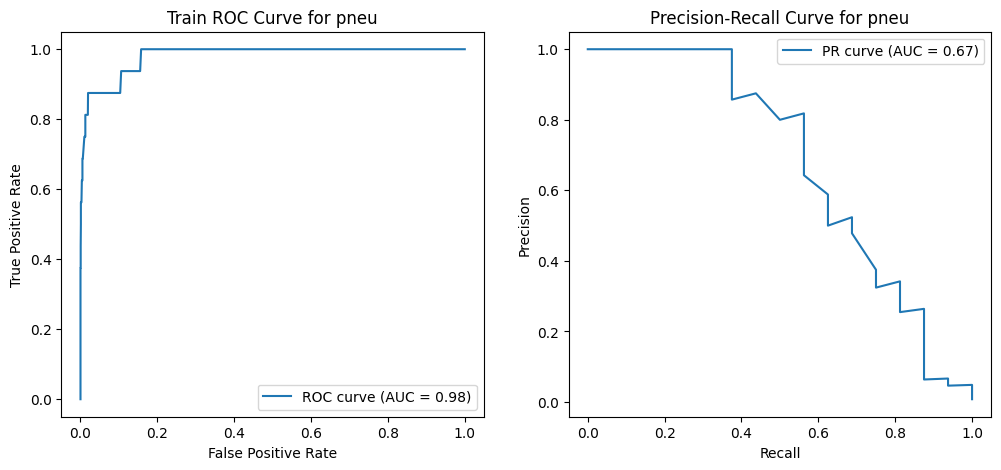

🔹 Đang chạy với target: inf


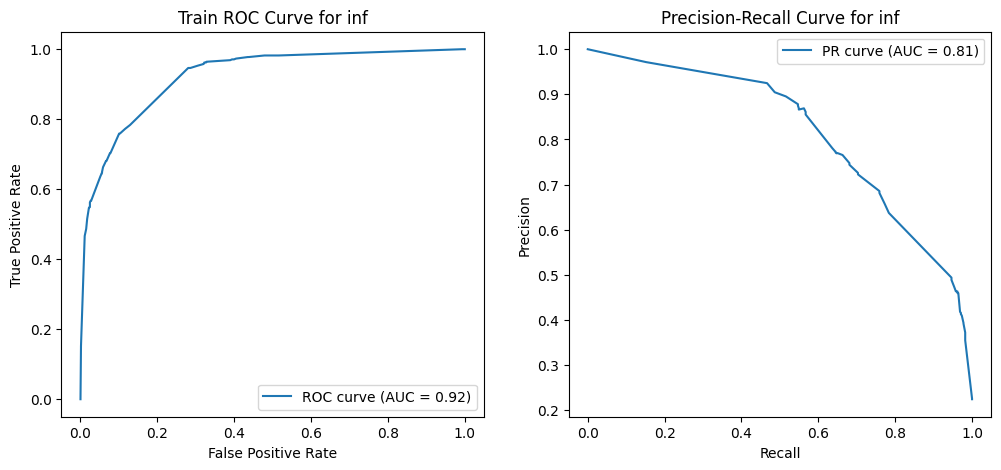

In [9]:
### TRAIN Text for 5 symps
symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

result = pd.DataFrame(columns=["precision", "recall", "f1", "accuracy"])
XG_models = {}

for i in symptoms:
    metrics, model = XGBoost_model_train(i, train_df, test_df)  # Đảm bảo NN_model_train trả về tuple
    result.loc[len(result)] = metrics  # Gán giá trị metrics vào hàng mới
    XG_models[i] = model  # Lưu mô hình vào dictionary
    
### TRAIN BN for pneu/inf
targets = ["pneu", "inf"]
BN_models = {
    'pneu': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "pneu"),
    'inf': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "inf")
}

dysp - Output shape: (2000,)
cough - Output shape: (2000,)
pain - Output shape: (2000,)
fever - Output shape: (2000,)
nasal - Output shape: (2000,)
['asthma', 'smoking', 'COPD', 'winter', 'hay_fever', 'pneu', 'inf']
Nodes in Bayesian Network: ['smoking', 'COPD', 'cough', 'dysp', 'asthma', 'pneu', 'hay_fever', 'nasal', 'pain', 'winter', 'inf', 'fever']
Columns in test_features: ['asthma', 'smoking', 'COPD', 'winter', 'hay_fever', 'inf', 'dysp', 'cough', 'pain', 'fever', 'nasal']


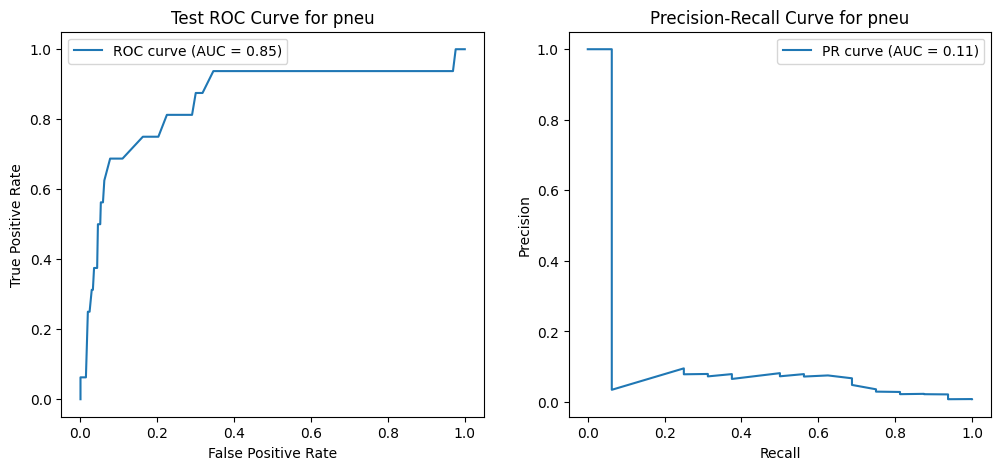

Nodes in Bayesian Network: ['smoking', 'COPD', 'cough', 'dysp', 'asthma', 'pneu', 'hay_fever', 'nasal', 'pain', 'winter', 'inf', 'fever']
Columns in test_features: ['asthma', 'smoking', 'COPD', 'winter', 'hay_fever', 'pneu', 'dysp', 'cough', 'pain', 'fever', 'nasal']


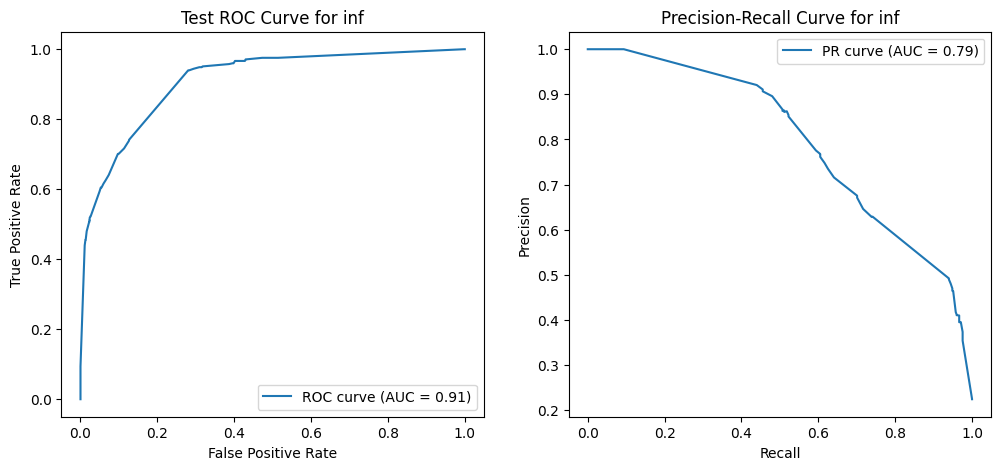

In [10]:
### TEST text -> symps -> target
feature_df = test_XGBoost(XG_models, test_df, emb='hist_emb')
for target in targets:
    y_pred = test_BN(feature_df, BN_models[target], target)

In [11]:
print("Result for symps")
result

Result for symps


,precision,recall,f1,accuracy
0,0.964384,0.882206,0.921466,0.9700
1,0.963020,0.932836,0.947688,0.9655
2,0.944444,0.602837,0.735931,0.9390
3,0.911462,0.910000,0.901955,0.9100
4,0.956341,0.898438,0.926485,0.9635
